# MMSA: Seismic Functionality Analysis for Interdependent Buildings-Water-Power using Fragility and Repair Rate Curves

This notebook uses pyIncore to compute seismic damages to buildings, potable water infrastructure, and electric power infrastructure serving Shelby County, TN. We also conduct probabilistic functionality analysis for power and water infrastructure based on network connectivity.

Notebook originally created by:
- Neetesh Sharma (UIUC - nsharm11@illinois.edu)
- Armin Tabandeh (UIUC - tabande2@illinois.edu)
- Paolo Gardoni (UIUC - gardoni@illinois.edu)

More information about the testbed and the field study can be found in these publications:
- Sharma, N., & Gardoni, P. (2019). Modeling the time-varying performance of electrical infrastructure during post       disaster recovery using tensors. In P. Gardoni (Ed.), *Handbook of sustainable and resilient infrastructure* **(pp.   259–276)**. New York, NY: Routledge.
- Sharma, N., Tabandeh, A., & Gardoni, P. (2019). Regional resilience analysis: A multi-scale approach to model the 
  recovery of interdependent infrastructure. In P. Gardoni (Ed.), *Handbook of sustainable and resilient 
  infrastructure* (pp. 521–544). New York, NY: Routledge.
- Sharma, N., Tabandeh, A., & Gardoni, P. (2020). Regional resilience analysis: A multi-scale approach to optimize 
  the resilience of interdependent infrastructure. *Computer‐Aided Civil and Infrastructure Engineering*, **35(12)**, 
  1315-1330.
- Sharma, N., & Gardoni, P. (2022). Mathematical modeling of interdependent infrastructure: An object-oriented 
  approach for generalized network-system analysis. *Reliability Engineering & System Safety*, **217**, 108042.

***
### 1. Background
Shelby County has a population of approximately 1,000,000 people, and the region is subject to seismic hazards originating from the New Madrid Seismic Zone. As a disrupting event, we model a 7.9 magnitude earthquake with epicenter at 35.927N and 89.919W (i.e., North-West of ShelbyCounty).

### 2. Description of buidings and infrastructure
Buildings, potable water infrastructure, and electric power infrastructure are the physical systems considered in this example. We have the required physical and demographic data for every building in Shelby County. The existing fragility functions of buildings require information about the structure type, occupancy type, and the number of stories. The details of the datasets and fragility functions are in the documentation of the risk assessment software MAEViz, developed by the Mid-America Earthquake (MAE) Center (http://mae.cee.illinois.edu/). The majority of the buildings in Shelby County are residential; however, the commercial and industrial buildings are critical to business operations and economic vitality of the county and place comparable demands on the infrastructure to those of the entire residential buildings.

Memphis Light, Gas and Water (MLGW) division serves Shelby County with potable water and electric power. The potable water infrastructure is confined to Shelby County since water is locally drawn from the Memphis Aquifer in Shelby County. The power supplier to MLGW is the Tennessee Valley Authority (TVA) that constitutes balancing authority in the state of Tennessee. In this notebook, the infrastructure data are from MAEViz , which include the locations of potable water and electric power facilities and potable water pipelines within Shelby County.

***
### 3. pyIncore
The remainder of this notebook uses pyIncore to compute damages to buildings and infrastructure in Shelby County, TN.

#### 3.1 Prerequisites

The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**.

| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>1.6.0 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| pyIncore_viz | =>1.7.0 | see: https://incore.ncsa.illinois.edu/doc/pyincore_viz/index.html |

#### 3.2 Importing Python Modules
In this analysis, we use the following models from pyIncore:
+ **BuildingDamage**: Computes the probability of each building being in a damage state given the seismic hazard model defined in incore.
+ **PipelineDamageRepairRate**: Computes the number of leaks and breaks per unit length of water pipelines given the seismic hazard model.
+ **WaterFacilityDamage**: Computes the probability of each water facility being in a damage state given the seismic hazard model.
+ **EpfDamage**: Computes the probability of each power substation being in a damage state given the seismic hazard model.
+ **MonteCarloFailureProbability**: Samples from damage state probability mass functions
+ **PipelineFunctionality**: Computes average pipeline functionality
+ **EpnFunctionality**: Computes functionality probability and failure states for a corresponding electric power network
+ **WfnFunctionality**: Computes functionality probability and failure states for a corresponding water network

We also use other Python libraries and functions that are required for network connectivity analysis
+ **networkx**: Enables creating network datasets and running shortest path analyses.
+ **copy**: Enables creating copies of mutable objects such as dataframes and network objects.
+ **scipy.stats**: Provides probability distributions for random variables.
+ **pandas**: Provides functions for manipulating dataframe objects.
+ **numpy**: Provides functions for manipulating array objects.
+ **matplotlib**: Provides functions for plotting.

In [1]:
from pyincore import HazardService, IncoreClient, Dataset, FragilityService, MappingSet, DataService, SpaceService, \
NetworkDataset, NetworkUtil
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.pipelinedamagerepairrate import PipelineDamageRepairRate
from pyincore.analyses.waterfacilitydamage import WaterFacilityDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore_viz.geoutil import GeoUtil as viz
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability
from pyincore.analyses.pipelinefunctionality import PipelineFunctionality
from pyincore.analyses.epnfunctionality import EpnFunctionality
from pyincore.analyses.wfnfunctionality import WfnFunctionality

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape
import contextily as ctx

In [2]:
client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 1.5.0


### 4. Defining the seismic characteristics of the scenario earthquake

We use a predefined seismic event from the pyIncore repository, which corresponds to the characteristics of a historical event in the region. To model the spatial variation of the earthquake intensity measures, we use the ground motion prediction equation by Atkinson and Boore (1995). One can consult the Incore documentation to define other earthquake scenarios or use other ground motion prediction equations.

In [3]:
hazardsvc = HazardService(client)
# New Madrid earthquake using Atkinson Boore 1995
hazard_type = "earthquake"
hazard_id = "5b902cb273c3371e1236b36b" #Predefined id

# Look at the eathquake scenario characteristics used in this example
earthquake_model_metadata = hazardsvc.get_earthquake_hazard_metadata(hazard_id)
earthquake_model_metadata

{'eqType': 'model',
 'id': '5b902cb273c3371e1236b36b',
 'name': 'Memphis 7.9 AB-95',
 'description': 'Memphis new madrid atkinson and boore 1995 model based hazard',
 'date': '2022-07-26T18:13:14+0000',
 'creator': 'cnavarro',
 'spaces': ['ergo', 'cnavarro', 'coe', 'incore'],
 'attenuations': {'AtkinsonBoore1995': 1.0},
 'eqParameters': {'srcLatitude': 35.927,
  'srcLongitude': -89.919,
  'magnitude': 7.9,
  'coseismicRuptureDepth': 0.0,
  'dipAngle': 0.0,
  'azimuthAngle': 0.0,
  'rakeAngle': 0.0,
  'seismogenicDepth': 0.0,
  'depth': 10.0,
  'depth2p5KmPerSecShearWaveVelocity': 2.0,
  'shearWaveDepth1p0': 0.0,
  'faultTypeMap': {},
  'region': 'Global'},
 'visualizationParameters': {'demandType': 'PGA',
  'demandUnits': 'g',
  'minX': -90.3099,
  'minY': 34.9942,
  'maxX': -89.6231,
  'maxY': 35.4129,
  'numPoints': 1025,
  'amplifyHazard': True},
 'defaultSiteClass': 'D',
 'siteAmplification': 'NEHRP',
 'rasterDataset': {'hazardType': 'deterministic',
  'datasetId': '5b902cb173c3371

### 5. Building damage analysis

We use the building inventory available in the pyIncore. In case a new dataset needs to be defined, one can use the formatting of this dataset and create their own and ingest into Incore. The default fragilities in pyIncore are inhereted from MAEViz. For more information refer to MAE center reports at http://mae.cee.illinois.edu/publications/publications_reports.html 

In [4]:
# Building inventory in Shelby county, TN
bldg_dataset_id = "5a284f0bc7d30d13bc081a46"
#bldg_dataset_id = "5a284f0bc7d30d13bc081a28"
# Default Building Fragility mapping
bldg_mapping_id = "5b47b350337d4a3629076f2c"

In [5]:
#Looking at the attribute table for the inventory
bldg_dataset = Dataset.from_data_service(bldg_dataset_id, DataService(client))
bldg_dataset.get_dataframe_from_shapefile().head()

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


,parid,parid_card,bldg_id,struct_typ,str_prob,year_built,no_stories,a_stories,b_stories,bsmt_type,...,dgn_lvl,cont_val,efacility,dwell_unit,str_typ2,occ_typ2,tract_id,guid,IMPUTED,geometry
0,038035 00019,038035 00019_1,038035 00019_1_1,URM,0.02633,1920,1,1,0,CRAWL=0-24%,...,Pre - Code,46707,FALSE,1,URML,RES1,47157001300,64124791-1502-48ea-81b6-1992855f45d5,F,POINT (-89.94883 35.15122)
1,038034 00040,038034 00040_1,038034 00040_1_1,W1,0.97366,1947,1,1,0,CRAWL=0-24%,...,Low - Code,39656,FALSE,1,W1,RES1,47157001300,d04da316-7cba-4964-8104-f0edfde18239,F,POINT (-89.95095 35.15284)
2,038028 00023,038028 00023_1,038028 00023_1_1,W1,0.97366,1900,1,1,0,CRAWL=0-24%,...,Low - Code,37765,FALSE,1,W1,RES1,47157001300,c24d708d-a21b-416f-8772-965548407231,F,POINT (-89.95022 35.15976)
3,034011 00008,034011 00008_1,034011 00008_1_1,W1,0.97366,1926,1,1,0,CRAWL=0-24%,...,Low - Code,59930,FALSE,1,W1,RES1,47157005700,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,F,POINT (-90.04844 35.10446)
4,034011 00007,034011 00007_1,034011 00007_1_1,W1,0.97366,1926,1,1,0,CRAWL=0-24%,...,Low - Code,65276,FALSE,1,W1,RES1,47157005700,ef25f515-4109-408f-a3d4-3b79da49edd0,F,POINT (-90.04843 35.10459)


#### 5.1 Buidling damage

In [6]:
# Create building damage
bldg_dmg = BuildingDamage(client)

# Load input dataset
bldg_dmg.set_input_dataset("buildings", bldg_dataset)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(bldg_mapping_id))
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [7]:
# Set analysis parameters
bldg_dmg.set_parameter("result_name", "memphis_bldg_dmg_result")
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 8)

True

In [8]:
# Run building damage analysis
bldg_dmg.run_analysis()

True

In [9]:
# Retrieve result dataset
bldg_dmg_result = bldg_dmg.get_output_dataset("ds_result")

# Convert dataset to Pandas DataFrame
bldg_dmg_df = bldg_dmg_result.get_dataframe_from_csv()

# Display top 5 rows of output data
bldg_dmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3,haz_expose
0,64124791-1502-48ea-81b6-1992855f45d5,0.765693,0.196848,0.010265,0.234307,0.568845,0.186583,0.010265,yes
1,d04da316-7cba-4964-8104-f0edfde18239,0.553140,0.104687,0.004094,0.446860,0.448453,0.100592,0.004094,yes
2,c24d708d-a21b-416f-8772-965548407231,0.558730,0.107277,0.004269,0.441270,0.451453,0.103009,0.004269,yes
3,6ff63801-3bf4-4bf3-b6e5-ff9d5fe6f0d0,0.509678,0.086185,0.002948,0.490322,0.423493,0.083237,0.002948,yes
4,ef25f515-4109-408f-a3d4-3b79da49edd0,0.509779,0.086225,0.002950,0.490221,0.423554,0.083275,0.002950,yes


#### 5.2 Creating a chart
The results dataset is a pandas dataframe and various plotting libraries available in python can be used to visualize the data. For example, following is a barplot of the number of buildings in each of the damage states.

In [10]:
# TODO: will include this in the next pyincore-viz release
# Code for creating the combined map 
# We create our own function by editing the existing code from pyincoreviz and add it to the pyincore viz class
def my_plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik,ax=None,legend = True, legend_kwds = None,cmap=None,marker="o"):
    """Plot Geopandas DataFrame.
    Args:
        gdf (obj): Geopandas DataFrame object.
        column (str): A column name to be plot.
        category (bool): Turn on/off category option.
        basemap (bool): Turn on/off base map (e.g. openstreetmap).
        source(obj): source of the Map to be used. examples, ctx.providers.OpenStreetMap.Mapnik (default),
            ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron etc.
    """
    if isinstance(ax, type(None)):
        gdf = gdf.to_crs(epsg=3857)
        ax = gdf.plot(figsize=(10, 10), column=column,
                      categorical=category, legend=legend , legend_kwds = legend_kwds,cmap=cmap)
        if basemap:
            ctx.add_basemap(ax, source=source)
    else:
        gdf = gdf.to_crs(epsg=3857)
        gdf.plot(ax=ax,column=column,
              categorical=category, legend=legend , legend_kwds = legend_kwds,cmap=cmap,marker=marker)
    return ax
setattr(viz, "my_plot_gdf_map", my_plot_gdf_map)

Text(0, 0.5, 'Counts')

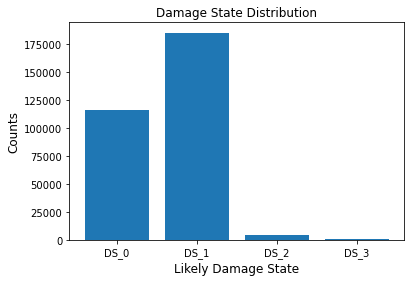

In [11]:
DSlist = np.array(['DS_0', 'DS_1', 'DS_2', 'DS_3'])
bldg_likelyDS = DSlist[bldg_dmg_df.loc[:,['DS_0', 'DS_1', 'DS_2', 'DS_3']].values.argmax(axis=1)]
bldg_dmg_df['likelyDS'] = bldg_likelyDS
keys, counts = np.unique(bldg_likelyDS, return_counts=True)

fig, ax = plt.subplots()
ax.bar(keys, counts)
ax.set_title("Damage State Distribution", fontsize=12)
ax.set_xlabel("Likely Damage State", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

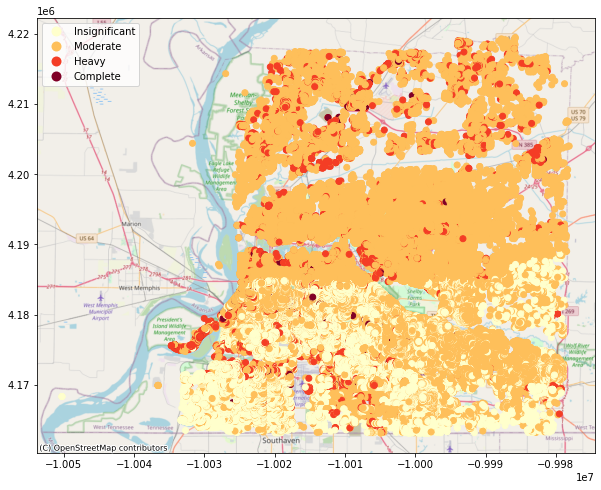

In [12]:
#Plotting the most likely damage state for buldings
building_gdf = bldg_dataset.get_dataframe_from_shapefile()
joined_building_gdf = building_gdf.set_index("guid").join(bldg_dmg_df.set_index("guid"))

ax = viz.my_plot_gdf_map(joined_building_gdf,column='likelyDS',category = True,basemap=True,cmap='YlOrRd')
orddict={'DS_0': 'Insignificant', 'DS_1': 'Moderate', 'DS_2': 'Heavy', 'DS_3': 'Complete'}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), orddict)

### 6. Infrastructure Damage Analysis

We use the infrastructure data from MAEViz available in pyIncore. These data include the locations of potable water and electric power facilities and potable water pipelines within Shelby County. 

&nbsp;&nbsp;&nbsp;&nbsp;The potable water pipeline repair rates and component fragilities are from ALA https://www.americanlifelinesalliance.com/pdf/Part_1_Guideline.pdf, and HAZUS https://www.fema.gov/sites/default/files/2020-09/fema_hazus_earthquake-model_technical-manual_2.1.pdf. The electrical power substation fragilities are also from HAZUS.

#### 6.1 Potable water pipelines and facilities

In [13]:
data_services = DataService(client)

##### Load water network and its components in Shelby county, TN

In [14]:
water_network_dataset_id = "62d586120b99e237881b0519"
water_network_dataset = Dataset.from_data_service(water_network_dataset_id, data_services)
water_network = NetworkDataset.from_dataset(water_network_dataset)
pipeline_dataset = water_network.links
waterfacility_dataset = water_network.nodes

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


##### 6.1.1 Pipeline damage repair rate

In [15]:
# pipeline fragility mapping
pp_mapping_id = "5b47c227337d4a38464efea8"

# Geology dataset
liq_geology_dataset_id = "5a284f53c7d30d13bc08249c"
liq_fragility_key = "pgd"
use_liq = True

In [16]:
# Create pipeline damage with repair rate
pipeline_dmg_w_rr = PipelineDamageRepairRate(client)

# Load pipeline inventory as input datasets
pipeline_dmg_w_rr.set_input_dataset("pipeline", pipeline_dataset)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(pp_mapping_id))
pipeline_dmg_w_rr.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [17]:
# Set analysis parameters
pipeline_dmg_w_rr.set_parameter("result_name", "pipeline_result")
pipeline_dmg_w_rr.set_parameter("hazard_type", hazard_type)
pipeline_dmg_w_rr.set_parameter("hazard_id", hazard_id)
pipeline_dmg_w_rr.set_parameter("liquefaction_fragility_key", liq_fragility_key)
pipeline_dmg_w_rr.set_parameter("liquefaction_geology_dataset_id",liq_geology_dataset_id)
pipeline_dmg_w_rr.set_parameter("use_liquefaction", use_liq)
pipeline_dmg_w_rr.set_parameter("num_cpu", 4)

True

In [18]:
# Run pipeline  damage analysis
pipeline_dmg_w_rr.run_analysis()

True

In [19]:
# Retrieve result dataset
pipeline_dmg_result = pipeline_dmg_w_rr.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pipeline_dmg_df = pipeline_dmg_result.get_dataframe_from_csv()

# Display top 5 rows of output data
pipeline_dmg_df.head()

,guid,pgvrepairs,pgdrepairs,repairspkm,breakrate,leakrate,failprob,numpgvrpr,numpgdrpr,numrepairs,haz_expose
0,0a076a0d-54fa-4f82-a8af-ce3bd227fcfa,0.061053,9.017529,9.078582,7.226234,1.852348,1.000000,0.155686,22.994699,23.150385,yes
1,cee37f5e-6e62-40e6-be5a-485d5c78bd25,0.050801,7.048335,7.099136,5.648828,1.450307,0.999996,0.110745,15.365370,15.476116,yes
2,77f5d8b6-ad73-4959-b357-0c512d8f2bcd,0.022929,3.041846,3.064775,2.438063,0.626713,1.000000,0.254516,33.764490,34.019006,yes
3,07267d06-089e-4db7-a479-1794cdc23be3,0.035117,4.167356,4.202473,3.340908,0.861565,1.000000,0.184718,21.920291,22.105008,yes
4,ec3d4c41-ae4a-4489-9984-1d96e7f4ae06,0.040063,4.577325,4.617389,3.669873,0.947516,1.000000,0.488774,55.843367,56.332141,yes


##### 6.1.2 water facility damage

In [20]:
# Water facility inventory for Shelby County, TN
# Inaccurate attributes, needed to be changed in the following cell

# Default water facility fragility mapping
# wf_mapping_id = "5b47c3b1337d4a387e85564b"  # Hazus Potable Water Facility Fragility Mapping - Only PGA
wf_mapping_id = "5b47c383337d4a387669d592" # Potable Water Facility Fragility Mapping for INA - Has PGD
fragility_key = "pga"

# Liquefaction parameters
liq_geology_dataset_id =  "5a284f53c7d30d13bc08249c"
liquefaction = True
liq_fragility_key = "pgd"

# Hazard uncertainty
uncertainty = False

In [21]:
# Create water facility damage analysis
wf_dmg = WaterFacilityDamage(client)

# Load water facility inventory dataset
wf_dmg.set_input_dataset("water_facilities", waterfacility_dataset)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(wf_mapping_id))
wf_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [22]:
# Set analysis parameters
wf_dmg.set_parameter("result_name", "wf-dmg-results")
wf_dmg.set_parameter("hazard_type", hazard_type)
wf_dmg.set_parameter("hazard_id", hazard_id)
wf_dmg.set_parameter("fragility_key", fragility_key)
wf_dmg.set_parameter("use_liquefaction", liquefaction)
wf_dmg.set_parameter("liquefaction_geology_dataset_id", liq_geology_dataset_id)
wf_dmg.set_parameter("liquefaction_fragility_key", liq_fragility_key)
wf_dmg.set_parameter("use_hazard_uncertainty", uncertainty)
wf_dmg.set_parameter("num_cpu", 4)

True

In [23]:
# Run water facility damage analysis
wf_dmg.run_analysis()

True

In [24]:
# Retrieve result dataset
wf_dmg_result = wf_dmg.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
wf_dmg_df = wf_dmg_result.get_dataframe_from_csv()

# Display top 5 rows of output data
wf_dmg_df.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose
0,fa8f588c-1180-4033-ba6d-28660dcb7112,0.593220,0.351932,0.199350,0.164453,0.406780,0.241288,0.152582,0.034897,0.164453,yes
1,7a78c727-bc47-4010-bed6-7775660dc6f6,0.589678,0.348308,0.196541,0.162051,0.410322,0.241370,0.151767,0.034489,0.162051,yes
2,cced02f4-a461-44e5-9a31-3a6f9ee26738,0.649251,0.411418,0.246358,0.204439,0.350749,0.237833,0.165061,0.041919,0.204439,yes
3,49c79885-9252-4618-9d91-6d0c1195e93e,0.690963,0.458584,0.284920,0.236986,0.309037,0.232379,0.173664,0.047934,0.236986,yes
4,a699e027-f484-4d2b-960d-c1c2aa500724,0.713794,0.485577,0.307562,0.256003,0.286206,0.228218,0.178014,0.051559,0.256003,yes


In [25]:
# TODO: junctions are not mapped hence empty; which causes problem in MC simulation later
wf_dmg_df = wf_dmg_df.dropna()
wf_dmg_result_modified = Dataset.from_dataframe(wf_dmg_df, name="wf_dmg_result_modified", data_type="ergo:waterFacilityDamageVer6")

In [26]:
DSlist = np.array(['DS_0', 'DS_1', 'DS_2','DS_3','DS_4'])
wf_dmg_df['likelyDS'] = DSlist[wf_dmg_df.loc[:,['DS_0', 'DS_1', 'DS_2', 'DS_3','DS_4']].values.argmax(axis=1)]

In [27]:
# Plotting the damage to water pipelines and facilities together and also showing the junctions
pipeline_gdf = pipeline_dataset.get_dataframe_from_shapefile()
joined_pipeline_gdf = pipeline_gdf.set_index("guid").join(pipeline_dmg_df.set_index("guid"))

waterfacility_gdf = waterfacility_dataset.get_dataframe_from_shapefile()
joined_waterfacility_gdf = waterfacility_gdf[waterfacility_gdf["utilfcltyc"] != "Junction"]
joined_waterfacility_gdf = joined_waterfacility_gdf.set_index("guid").join(wf_dmg_df.set_index("guid"))

waterjunctions_gdf = waterfacility_gdf[waterfacility_gdf["utilfcltyc"] == "Junction"]
joined_waterjunctions_gdf = waterjunctions_gdf.set_index("guid").join(wf_dmg_df.set_index("guid"))

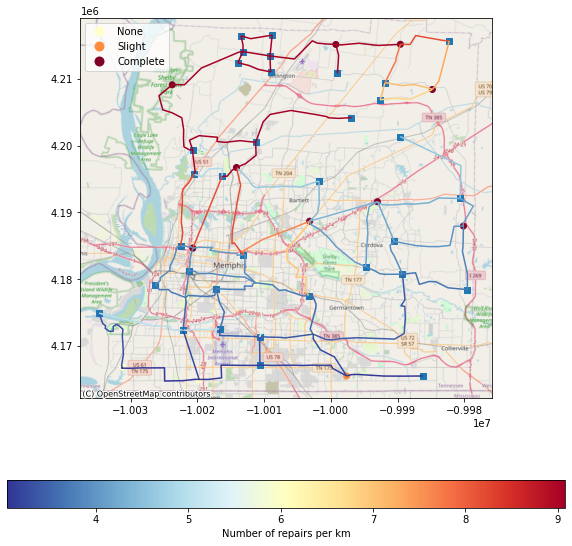

In [28]:
legend_kwds = {'label': "Number of repairs per km",'orientation': "horizontal"}
ax = viz.my_plot_gdf_map(joined_pipeline_gdf,'repairspkm',basemap=True,legend_kwds=legend_kwds,cmap='RdYlBu_r')
ax = viz.my_plot_gdf_map(waterjunctions_gdf,column='utilfcltyc',category = True,basemap=True,ax=ax,marker="s")
ax = viz.my_plot_gdf_map(joined_waterfacility_gdf,column='likelyDS',category = True,basemap=True,ax=ax,cmap='YlOrRd')

orddict={'DS_0': 'None', 'DS_1': 'Slight', 'DS_2': 'Moderate', 'DS_3': 'Extensive','DS_4': 'Complete'}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), orddict)

#### 6.2 Electric power transmission lines and facilities

##### Load Electric power network and its components in Shelby county, TN

In [29]:
# Electric power transmission lines dataset
epn_network_dataset_id = '62d85b399701070dbf8c65fe'
epn_network_dataset = Dataset.from_data_service(epn_network_dataset_id, data_services)
epn_network = NetworkDataset.from_dataset(epn_network_dataset)

In [30]:
powerline_dataset = epn_network.links
powerline_dataset.get_dataframe_from_shapefile().head()

,linknwid,fromnode,tonode,direction,pipetype,length_km,capacity,guid,geometry
0,64,40,57,0,1,1.170,2000.0,7989c607-13d3-4cdb-a870-b2b13077932e,"LINESTRING (-89.98442 35.24436, -89.99402 35.2..."
1,4,2,12,1,1,4.330,2000.0,4244d566-ce97-4043-bc4c-c8697c0b69c7,"LINESTRING (-89.91818 35.04783, -89.88465 35.0..."
2,68,49,50,0,1,1.040,2000.0,91789e1d-7ccd-4fc9-8a9e-caa5e49cde58,"LINESTRING (-89.94637 35.07423, -89.93492 35.0..."
3,67,48,49,0,1,0.749,2000.0,ed30b9f1-035a-4eec-bf8e-4b945b033814,"LINESTRING (-89.95459 35.07395, -89.94637 35.0..."
4,69,51,52,0,1,2.230,2000.0,4fa9327a-76fa-4b9d-8b8d-a681144e5225,"LINESTRING (-90.07849 35.07034, -90.06731 35.0..."


In [31]:
powerfacility_dataset = epn_network.nodes
powerfacility_dataset.get_dataframe_from_shapefile().head()

,nodenwid,fltytype,strctype,utilfcltyc,flow,guid,geometry
0,59,2,0,ESSL,0.0,75941d02-93bf-4ef9-87d3-d882384f6c10,POINT (-89.83611 35.28708)
1,58,2,0,ESSL,0.0,35909c93-4b29-4616-9cd3-989d8d604481,POINT (-89.84449 35.26734)
2,57,2,0,ESSL,0.0,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,POINT (-89.98442 35.24436)
3,56,2,0,ESSL,0.0,b2bed3e1-f16c-483a-98e8-79dfd849d187,POINT (-89.95621 35.19269)
4,55,2,0,ESSL,0.0,ab011d7c-0e34-4e5d-9734-34f7858d4b68,POINT (-89.97992 35.19191)


##### 6.2.1 EPF damage

In [32]:
epf_mapping_id = "5b47be62337d4a37b6197a3a"
# Run epf damage 
epf_dmg = EpfDamage(client)
epf_dmg.set_input_dataset("epfs", powerfacility_dataset)
# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(epf_mapping_id))
epf_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [33]:
epf_dmg.set_parameter("result_name", "hazus_epf_dmg_result")
epf_dmg.set_parameter("hazard_type", hazard_type)
epf_dmg.set_parameter("hazard_id", hazard_id)
epf_dmg.set_parameter("num_cpu", 1)
# Run Analysis
epf_dmg.run_analysis()

True

In [34]:
# Retrieve result dataset
epf_dmg_result = epf_dmg.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
epf_dmg_df = epf_dmg_result.get_dataframe_from_csv()

# Display top 5 rows of output data
epf_dmg_df.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose
0,75941d02-93bf-4ef9-87d3-d882384f6c10,0.948893,0.684018,0.249431,0.039763,0.051107,0.264875,0.434587,0.209668,0.039763,yes
1,35909c93-4b29-4616-9cd3-989d8d604481,0.942472,0.662985,0.231285,0.035358,0.057528,0.279487,0.431700,0.195927,0.035358,yes
2,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,0.934358,0.638261,0.211441,0.030814,0.065642,0.296098,0.426820,0.180627,0.030814,yes
3,b2bed3e1-f16c-483a-98e8-79dfd849d187,0.913776,0.582829,0.172047,0.022615,0.086224,0.330947,0.410783,0.149432,0.022615,yes
4,ab011d7c-0e34-4e5d-9734-34f7858d4b68,0.912963,0.580817,0.170736,0.022360,0.087037,0.332146,0.410081,0.148376,0.022360,yes


In [35]:
DSlist = np.array(['DS_0', 'DS_1', 'DS_2','DS_3','DS_4'])
epf_dmg_df['likelyDS'] = DSlist[epf_dmg_df.loc[:,['DS_0', 'DS_1', 'DS_2', 'DS_3','DS_4']].values.argmax(axis=1)]
epf_dmg_df.head()

,guid,LS_0,LS_1,LS_2,LS_3,DS_0,DS_1,DS_2,DS_3,DS_4,haz_expose,likelyDS
0,75941d02-93bf-4ef9-87d3-d882384f6c10,0.948893,0.684018,0.249431,0.039763,0.051107,0.264875,0.434587,0.209668,0.039763,yes,DS_2
1,35909c93-4b29-4616-9cd3-989d8d604481,0.942472,0.662985,0.231285,0.035358,0.057528,0.279487,0.431700,0.195927,0.035358,yes,DS_2
2,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,0.934358,0.638261,0.211441,0.030814,0.065642,0.296098,0.426820,0.180627,0.030814,yes,DS_2
3,b2bed3e1-f16c-483a-98e8-79dfd849d187,0.913776,0.582829,0.172047,0.022615,0.086224,0.330947,0.410783,0.149432,0.022615,yes,DS_2
4,ab011d7c-0e34-4e5d-9734-34f7858d4b68,0.912963,0.580817,0.170736,0.022360,0.087037,0.332146,0.410081,0.148376,0.022360,yes,DS_2


In [36]:
# Plotting the damage to power facilities and also showing the powerlines
powerline_gdf = powerline_dataset.get_dataframe_from_shapefile()

powerfacility_gdf = powerfacility_dataset.get_dataframe_from_shapefile()
joined_powerfacility_gdf = powerfacility_gdf.set_index("guid").join(epf_dmg_df.set_index("guid"))

In [37]:
viz.get_gdf_map([powerline_gdf, joined_powerfacility_gdf])

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

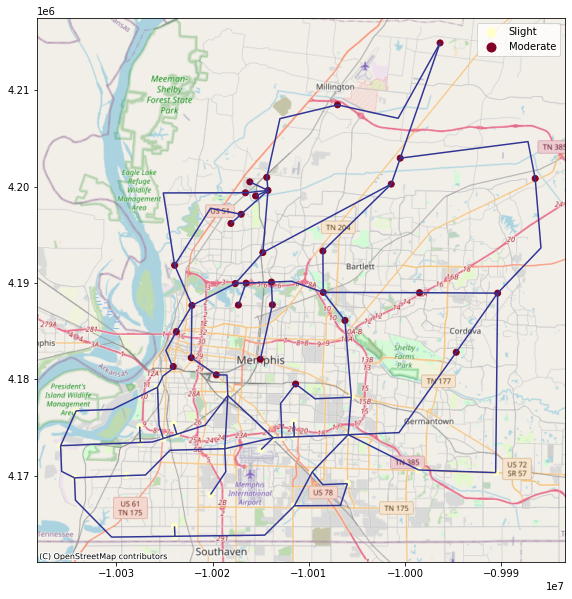

In [38]:
ax = viz.my_plot_gdf_map(powerline_gdf,'pipetype',category = True,basemap=True,cmap='RdYlBu_r')
ax = viz.my_plot_gdf_map(joined_powerfacility_gdf,column='likelyDS',category = True,basemap=True,ax=ax,cmap='YlOrRd')

orddict={'DS_0': 'None', 'DS_1': 'Slight', 'DS_2': 'Moderate', 'DS_3': 'Extensive','DS_4': 'Complete'}
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
replace_legend_items(ax.get_legend(), orddict)

### 7. Infrastructure Functionality Analysis

The next step in regional risk and resilience analysis is to estimate the impact of the damage in terms of loss of services. Here, we illustrate one of the typical methods to assess infrastructure functionality, using the connectivity analyses of damaged networks. 

#### 7.1 Potable Water Infrastructure 

##### 7.1.1 plot the water network

In [39]:
water_network_graph = water_network.get_graph_networkx()

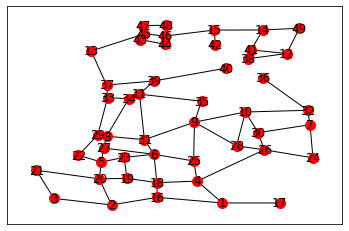

In [40]:
# # TODO: replace with our plot_network_graph in the next release
# NetworkUtil.plot_network_graph(water_network_graph, pos)
water_network_geoms = waterfacility_gdf[["nodenwid", "geometry"]]

pos = {}
for index, row in water_network_geoms.iterrows():
    pos[row["nodenwid"]] = np.array((row["geometry"].xy[0][0], row["geometry"].xy[1][0]))

labels=dict(zip(list(water_network_graph.nodes),water_network_graph.nodes))


nx.draw_networkx_nodes(water_network_graph,pos,node_size=100,node_color='r')
nx.draw_networkx_labels(water_network_graph,pos,labels)
nx.draw_networkx_edges(water_network_graph,pos)

##### 7.1.2 Montecarlo simulation compute water facility functionality

In [41]:
mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", wf_dmg_result_modified)
mc.set_parameter("result_name", "wf_dmg_mc")
mc.set_parameter("num_cpu", 8)
nsamp = 20000
mc.set_parameter("num_samples", nsamp)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc.set_parameter("failure_state_keys", ["DS_3", "DS_4"])
mc.run_analysis()

wf_dmg_fs = mc.get_output_dataset("sample_failure_state")
wf_dmg_fs.get_dataframe_from_shapefile().head()

,guid,failure,geometry
0,fa8f588c-1180-4033-ba6d-28660dcb7112,"1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,...",None
1,7a78c727-bc47-4010-bed6-7775660dc6f6,"1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,...",None
2,cced02f4-a461-44e5-9a31-3a6f9ee26738,"0,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,...",None
3,49c79885-9252-4618-9d91-6d0c1195e93e,"1,0,1,0,0,1,0,1,0,0,1,0,1,1,1,0,1,1,0,1,0,1,1,...",None
4,a699e027-f484-4d2b-960d-c1c2aa500724,"0,0,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,0,1,1,1,1,...",None


##### 7.1.3 Pipeline functionality 

In [42]:
pp_func = PipelineFunctionality(client)
pp_func.set_parameter("result_name", "mmsa_pipeline_functionality")
pp_func.set_parameter("num_samples", nsamp)
pp_func.set_input_dataset("pipeline_repair_rate_damage", pipeline_dmg_result)

pp_func.run_analysis()

pp_dmg_fs = pp_func.get_output_dataset("sample_failure_state")
pp_dmg_fs.get_dataframe_from_shapefile().head()

,guid,failure,geometry
0,0a076a0d-54fa-4f82-a8af-ce3bd227fcfa,"1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,...",None
1,cee37f5e-6e62-40e6-be5a-485d5c78bd25,"1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...",None
2,77f5d8b6-ad73-4959-b357-0c512d8f2bcd,"1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,...",None
3,07267d06-089e-4db7-a479-1794cdc23be3,"1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,0,1,1,1,0,0,...",None
4,ec3d4c41-ae4a-4489-9984-1d96e7f4ae06,"1,0,1,0,1,0,1,1,1,0,1,0,0,0,1,1,0,0,1,1,0,1,0,...",None


##### 7.1.4 Water network functionality

In [43]:
wfn_func = WfnFunctionality(client)

wfn_func.set_input_dataset("wfn_network", water_network_dataset)
wfn_func.set_input_dataset("wf_sample_failure_state", wf_dmg_fs)
wfn_func.set_input_dataset("pp_sample_failure_state", pp_dmg_fs)
wfn_func.set_parameter("result_name", "mmsa_wfn_functionality")
wfn_func.set_parameter("tank_node_list", [1, 7, 10, 13, 14, 15])
wfn_func.set_parameter("pumpstation_node_list", [2, 3, 4, 5, 6, 8, 9, 11, 12])

# Run Analysis
wfn_func.run_analysis()
wfn_dmg_fs = wfn_func.get_output_dataset("sample_failure_state")
wfn_dmg_fs_df = wfn_dmg_fs.get_dataframe_from_shapefile()
wfn_dmg_fs_df.head()

,guid,failure,geometry
0,d4599f71-07bd-4989-befb-aaa9c02bdffb,"1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",None
1,d28be28f-84b3-4ae9-985b-61423585fd5c,"1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1....",None
2,60820263-9de6-474d-a2c6-cb33ad5d2efa,"1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",None
3,6e7917b0-4ec4-45b0-ac13-c59f4c277e21,"1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",None
4,ffc82be0-9efe-4153-be58-92a020c03b2d,"1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1....",None


##### 7.1.4 Check for convergence
cov of the estimator for every node should be less than 0.05

In [44]:
new_wfn_dmg_fs_df = pd.DataFrame(
            np.array([np.array(wfn_dmg_fs_df.failure.values[i].split(',')).astype('float').astype('int')
                      for i in np.arange(wfn_dmg_fs_df.shape[0])]),
            index=wfn_dmg_fs_df.guid.values)

cov = new_wfn_dmg_fs_df.std(axis=1)/new_wfn_dmg_fs_df.mean(axis=1)/nsamp**0.5
cov.head()

d4599f71-07bd-4989-befb-aaa9c02bdffb    0.001195
d28be28f-84b3-4ae9-985b-61423585fd5c    0.006199
60820263-9de6-474d-a2c6-cb33ad5d2efa    0.000771
6e7917b0-4ec4-45b0-ac13-c59f4c277e21    0.000787
ffc82be0-9efe-4153-be58-92a020c03b2d    0.000826
dtype: float64

##### 7.1.5 Creating mean functionality dataframe

(array([ 7.,  5.,  2.,  5.,  4., 11.]),
 array([0.008, 0.172, 0.335, 0.498, 0.662, 0.825, 0.988]),
 <BarContainer object of 6 artists>)

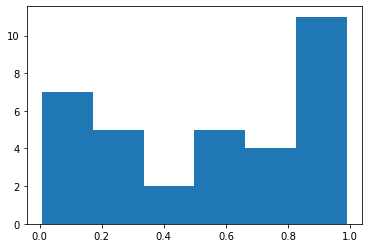

In [45]:
mean_func_df = pd.DataFrame(new_wfn_dmg_fs_df.mean(axis=1),columns=['functionality'])
mean_func_df['guid'] = mean_func_df.index
plt.hist(mean_func_df.functionality.values,6)

##### 7.1.6 Plotting the damage to water pipelines and facilities together and also showing the junctions

In [46]:
joined_waterjunctions_gdf = waterjunctions_gdf.set_index('guid').join(mean_func_df.set_index('guid'))

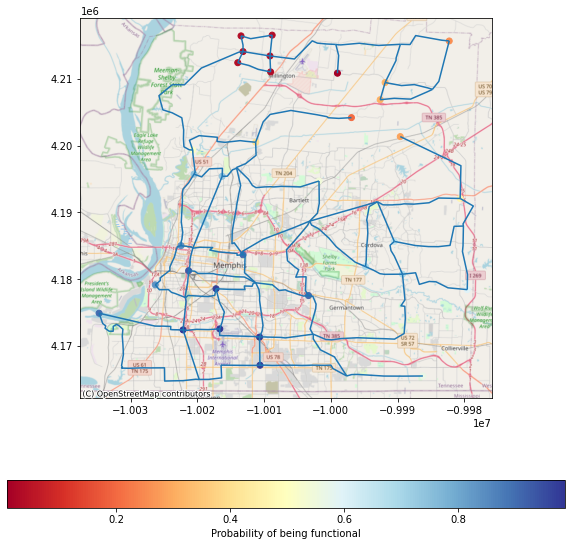

In [47]:
ax = viz.my_plot_gdf_map(pipeline_gdf,'pipelinehz',basemap=True,category=True,legend=False)
legend_kwds = {'label': "Probability of being functional",'orientation': "horizontal"}
ax = viz.my_plot_gdf_map(joined_waterjunctions_gdf,column='functionality',category = False,basemap=True,legend_kwds=legend_kwds,ax=ax,cmap='RdYlBu')

#### 7.2 Electric Power Infrastructure 

##### 7.2.1 Plot eletric power infrastructure

In [48]:
epn_network_graph = epn_network.get_graph_networkx()

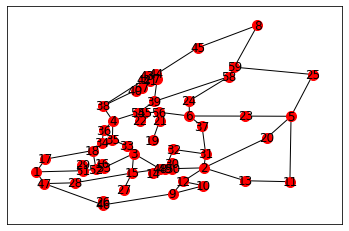

In [49]:
# # TODO: replace with our plot_network_graph in the next release
# NetworkUtil.plot_network_graph(epn_network_graph, pos)
epn_network_geoms = powerfacility_gdf[["nodenwid", "geometry"]]

pos = {}
for index, row in epn_network_geoms.iterrows():
    pos[row["nodenwid"]] = np.array((row["geometry"].xy[0][0], row["geometry"].xy[1][0]))

labels=dict(zip(list(epn_network_graph.nodes),epn_network_graph.nodes))

nx.draw_networkx_nodes(epn_network_graph,pos,node_size=100,node_color='r')
nx.draw_networkx_labels(epn_network_graph,pos,labels)
nx.draw_networkx_edges(epn_network_graph,pos)

##### 7.2.2 Montecarlo simulation compute electric power facility functionality¶

In [50]:
mc_ep = MonteCarloFailureProbability(client)
mc_ep.set_input_dataset("damage", epf_dmg_result)
mc_ep.set_parameter("result_name", "epf_dmg_mc")
mc_ep.set_parameter("num_cpu", 8)
nsamp = 1000
mc_ep.set_parameter("num_samples", nsamp)
mc_ep.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc_ep.set_parameter("failure_state_keys", ["DS_3", "DS_4"])
mc_ep.run_analysis()

True

In [51]:
epf_dmg_fs = mc_ep.get_output_dataset("sample_failure_state")
epf_dmg_fs.get_dataframe_from_csv().head()

,guid,failure
0,75941d02-93bf-4ef9-87d3-d882384f6c10,"1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,0,1,1,..."
1,35909c93-4b29-4616-9cd3-989d8d604481,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,..."
2,ce7d3164-ffda-4ac0-a9fa-d88c927897cc,"1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,b2bed3e1-f16c-483a-98e8-79dfd849d187,"1,0,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,..."
4,ab011d7c-0e34-4e5d-9734-34f7858d4b68,"1,0,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,1,..."


##### 7.2.3 Electric Power Network functionality

In [52]:
epn_func = EpnFunctionality(client)
epn_func.set_input_dataset("epn_network", epn_network_dataset)
epn_func.set_input_dataset("epf_sample_failure_state", epf_dmg_fs)

epn_func.set_parameter("result_name", "mmsa_epn_functionality")
epn_func.set_parameter("gate_station_node_list", [1, 2, 3, 4, 5, 6, 7, 8, 9])

# Run Analysis
epn_func.run_analysis()

True

In [53]:
epn_dmg_fs = epn_func.get_output_dataset("sample_failure_state")
epn_dmg_fs_df = epn_dmg_fs.get_dataframe_from_csv()
epn_dmg_fs_df.head()

,guid,failure
0,d658bb62-5b1e-4733-a53e-3805d4a2e2f4,"1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...."
1,2a5eff60-6cf3-4124-97fc-921fb9b73b6c,"1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...."
2,b3c6c503-417a-4d27-8fa0-db7837f7697c,"1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1...."
3,0174d606-3864-4d5d-acbe-4f7f10c36c8e,"1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1...."
4,059ef072-0910-4a33-86c6-9221e58e04bf,"1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0...."


##### 7.2.4 Check for convergence
cov of the estimator for every node should be less than 0.05

In [54]:
new_epn_dmg_fs_df = pd.DataFrame(
            np.array([np.array(epn_dmg_fs_df.failure.values[i].split(',')).astype('float').astype('int')
                      for i in np.arange(epn_dmg_fs_df.shape[0])]),
            index=epn_dmg_fs_df.guid.values)

cov = new_epn_dmg_fs_df.std(axis=1)/new_epn_dmg_fs_df.mean(axis=1)/nsamp**0.5
cov.head()

d658bb62-5b1e-4733-a53e-3805d4a2e2f4    0.011293
2a5eff60-6cf3-4124-97fc-921fb9b73b6c    0.010131
b3c6c503-417a-4d27-8fa0-db7837f7697c    0.010251
0174d606-3864-4d5d-acbe-4f7f10c36c8e    0.010191
059ef072-0910-4a33-86c6-9221e58e04bf    0.015472
dtype: float64

##### 7.2.5 Creating mean functionality dataframe

(array([ 5.,  2.,  6., 10., 13., 14.]),
 array([0.573, 0.633, 0.692, 0.752, 0.812, 0.871, 0.931]),
 <BarContainer object of 6 artists>)

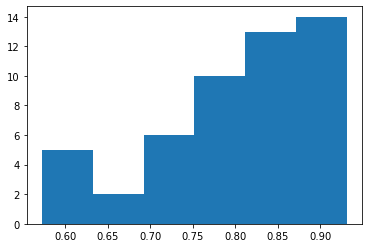

In [55]:
mean_func_ep_df = pd.DataFrame(new_epn_dmg_fs_df.mean(axis=1),columns=['functionality'])
mean_func_ep_df['guid'] = mean_func_ep_df.index
plt.hist(mean_func_ep_df.functionality.values,6)

##### 7.2.6 Plotting the damage to power facilities and also showing the powerlines

In [56]:
joined_powerfacility_gdf = powerfacility_gdf.set_index('guid').join(mean_func_ep_df.set_index('guid'))

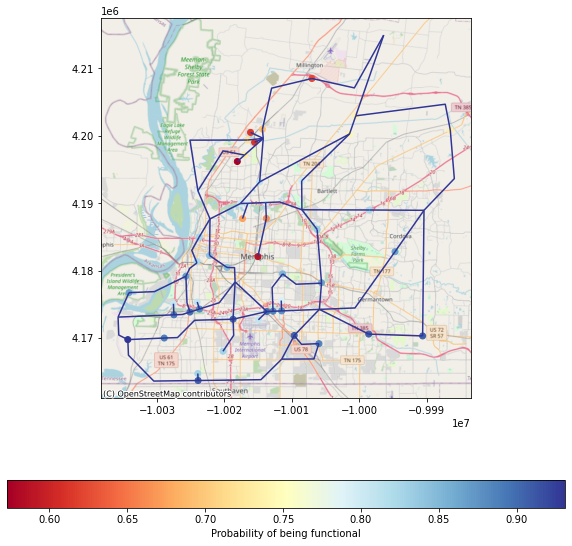

In [57]:
ax = viz.my_plot_gdf_map(powerline_gdf,'pipetype',category = True,basemap=True,legend=False,cmap='RdYlBu_r')
legend_kwds = {'label': "Probability of being functional",'orientation': "horizontal"}
ax = viz.my_plot_gdf_map(joined_powerfacility_gdf,column='functionality',category = False,legend_kwds=legend_kwds, basemap=True,ax=ax,cmap='RdYlBu')